In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/SI608 project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/SI608 project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from networkx import nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
import json
import operator

# A Music Recommendation System Based on Network

## 1. Data Manipulation

### 1.1 Data Cleaning

In [ ]:
'''
song_sample = pd.read_csv("subset-compiled.csv")
for i in ['artist_name', 'release', 'title']:
    for j in range(len(song_sample[i])):
        if song_sample[i][j][0:2] == "b'":
            temp = song_sample.loc[j, i]
            song_sample.loc[j, i] = re.findall(r"'(.*?)'", temp)[0]
        elif song_sample[i][j][0:2] == 'b"':
            temp = song_sample.loc[j, i]
            song_sample.loc[j, i] = re.findall(r"[\"](.*?)[\"]", temp)[0]
cols = set(song_sample.columns) - set(['artist_name', 'release', 'title'])
for i in cols:
    temp = str(song_sample[i][0])
    if temp[0] == "b":
        song_sample[i] = song_sample[i].str.extract(r"['\"](.*?)['\"]")
    if temp[0] == '(':
        song_sample[i] = song_sample[i].str.extract(r'\((.*?)\,')
song_sample.loc[song_sample.artist_playmeid == -1,'artist_playmeid'] = np.nan
song_sample.loc[song_sample.year == 0,'year'] = np.nan
song_sample.to_csv('cleaned-subset.csv',index=None)
'''
columns = ['song_id','artist_familiarity','artist_hotttnesss','duration',
           'loudness','mode_confidence','song_hotttnesss']
song_sample = pd.read_csv('cleaned-subset.csv',usecols=columns).fillna(0)

In [ ]:
'''
train = pd.read_table('train_triplets.txt.zip', compression='zip', names = ['user','song','play_count'])
train = train[train['song'].isin(song_sample['song_id'])]
train.to_csv('train_triplets_sample.csv',index=None)
'''
train = pd.read_csv('train_triplets_sample.csv')
song_sample = song_sample[song_sample['song_id'].isin(train['song'])]

### 1.2 Analysis

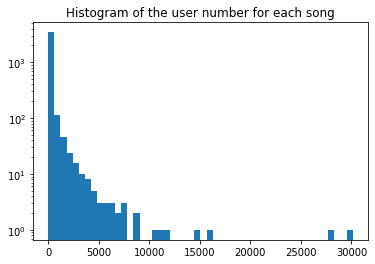

,song_id,count
0,SOULTKQ12AB018A183,30117
1,SOIZLKI12A6D4F7B61,28286
2,SOEHWGF12A6D4F8B2B,16128
3,SOEKSGJ12A67AE227E,14729
4,SOUCKDH12A8C138FF5,11610
...,...,...
3670,SOOCWAO12AB01852C1,1
3671,SOGDBUF12A8C140FAA,1
3672,SOLXOUI12AC468DBE2,1
3673,SOTLJGY12AB0188E32,1


In [ ]:
song_total = train.song.value_counts().reset_index()
song_total = song_total.rename(columns = {"index":"song_id", "song":"count"})
plt.hist(song_total['count'], bins=50)
plt.yscale('log')
plt.title('Histogram of the user number for each song')
plt.show()
song_total

The song with the max number of users has 30117 users.

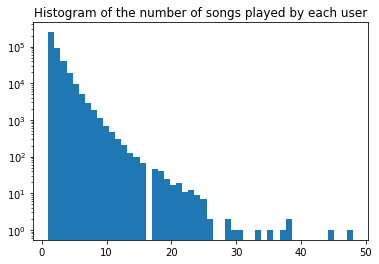

,user_id,count
0,ec6dfcf19485cb011e0b22637075037aae34cf26,48
1,c1255748c06ee3f6440c51c439446886c7807095,45
2,db6a78c78c9239aba33861dae7611a6893fb27d5,38
3,738759001498928d8dcb054cd53a1a0cfc200d36,38
4,d964fc033291078031d117ed10adfb615948256d,37
...,...,...
418247,34842f04392cc6b5b5936c1182cf6c7042c36103,1
418248,a8d5fdb55ce4748149ad081271b12d293bc7e9c3,1
418249,42e84651d34a1771d46855d8ff9a9e4893e0b28c,1
418250,c560910021a4d6c9f6f09256319c1237bab62085,1


In [ ]:
user_total = train.user.value_counts().reset_index()
user_total = user_total.rename(columns = {"index":"user_id", "user":"count"})
plt.hist(user_total['count'], bins=50)
plt.yscale('log')
plt.title('Histogram of the number of songs played by each user')
plt.show()
user_total

The user played the max number of songs played 48 songs.

The user number for each song and the song number for each user follow power law distribution.

In [ ]:
play_count = train.groupby('song').sum().reset_index()
play_count

,song,play_count
0,SOAAAQN12AB01856D3,217
1,SOAAEHR12A6D4FB060,957
2,SOAAFUV12AB018831D,10
3,SOAANKE12A8C13CF5C,5
4,SOAASSD12AB0181AA6,188
...,...,...
3670,SOZYUKG12A6D4FB64F,94
3671,SOZYZDZ12AB01873CA,6
3672,SOZZPYH12AB0187578,122
3673,SOZZQBH12A6D4FAFD8,63


### 1.3 Build the Network

In [ ]:
songs_dict = train.groupby('user')['song'].apply(list).to_dict()
with open("songs_dict.txt", "w") as fp:     
    json.dump(songs_dict, fp)
users_list = []
for i in songs_dict:
    users_list.append(i)
from itertools import combinations
pair_list = []
for i in songs_dict:
    for pair in combinations(songs_dict[i],2):
        pair_list.append(pair)
from collections import Counter
song_freq = Counter(pair_list) 

In [ ]:
song_g = nx.Graph()
for key, value in song_freq.items():
    song_g.add_edge(key[0],key[1],weight=value)

##### Because the graph is too big, I have to delete it in order to make this file easy to be opened, please refer to the README.md file to find the network graph.

In [1]:

print(nx.info(song_g))
print('Average shortest path length: ', nx.average_shortest_path_length(song_g))
print('Clustering coeff: ', nx.average_clustering(song_g))
plt.figure(figsize=(70,70))
nx.draw(song_g)


"\nprint(nx.info(song_g))\nprint('Average shortest path length: ', nx.average_shortest_path_length(song_g))\nprint('Clustering coeff: ', nx.average_clustering(song_g))\nplt.figure(figsize=(70,70))\nnx.draw(song_g)\n"

Name: 
Type: Graph
Number of nodes: 3535
Number of edges: 201495
Average degree: 114.0000
Average shortest path length:  2.2059332297527594
Clustering coeff:  0.3896164825242708


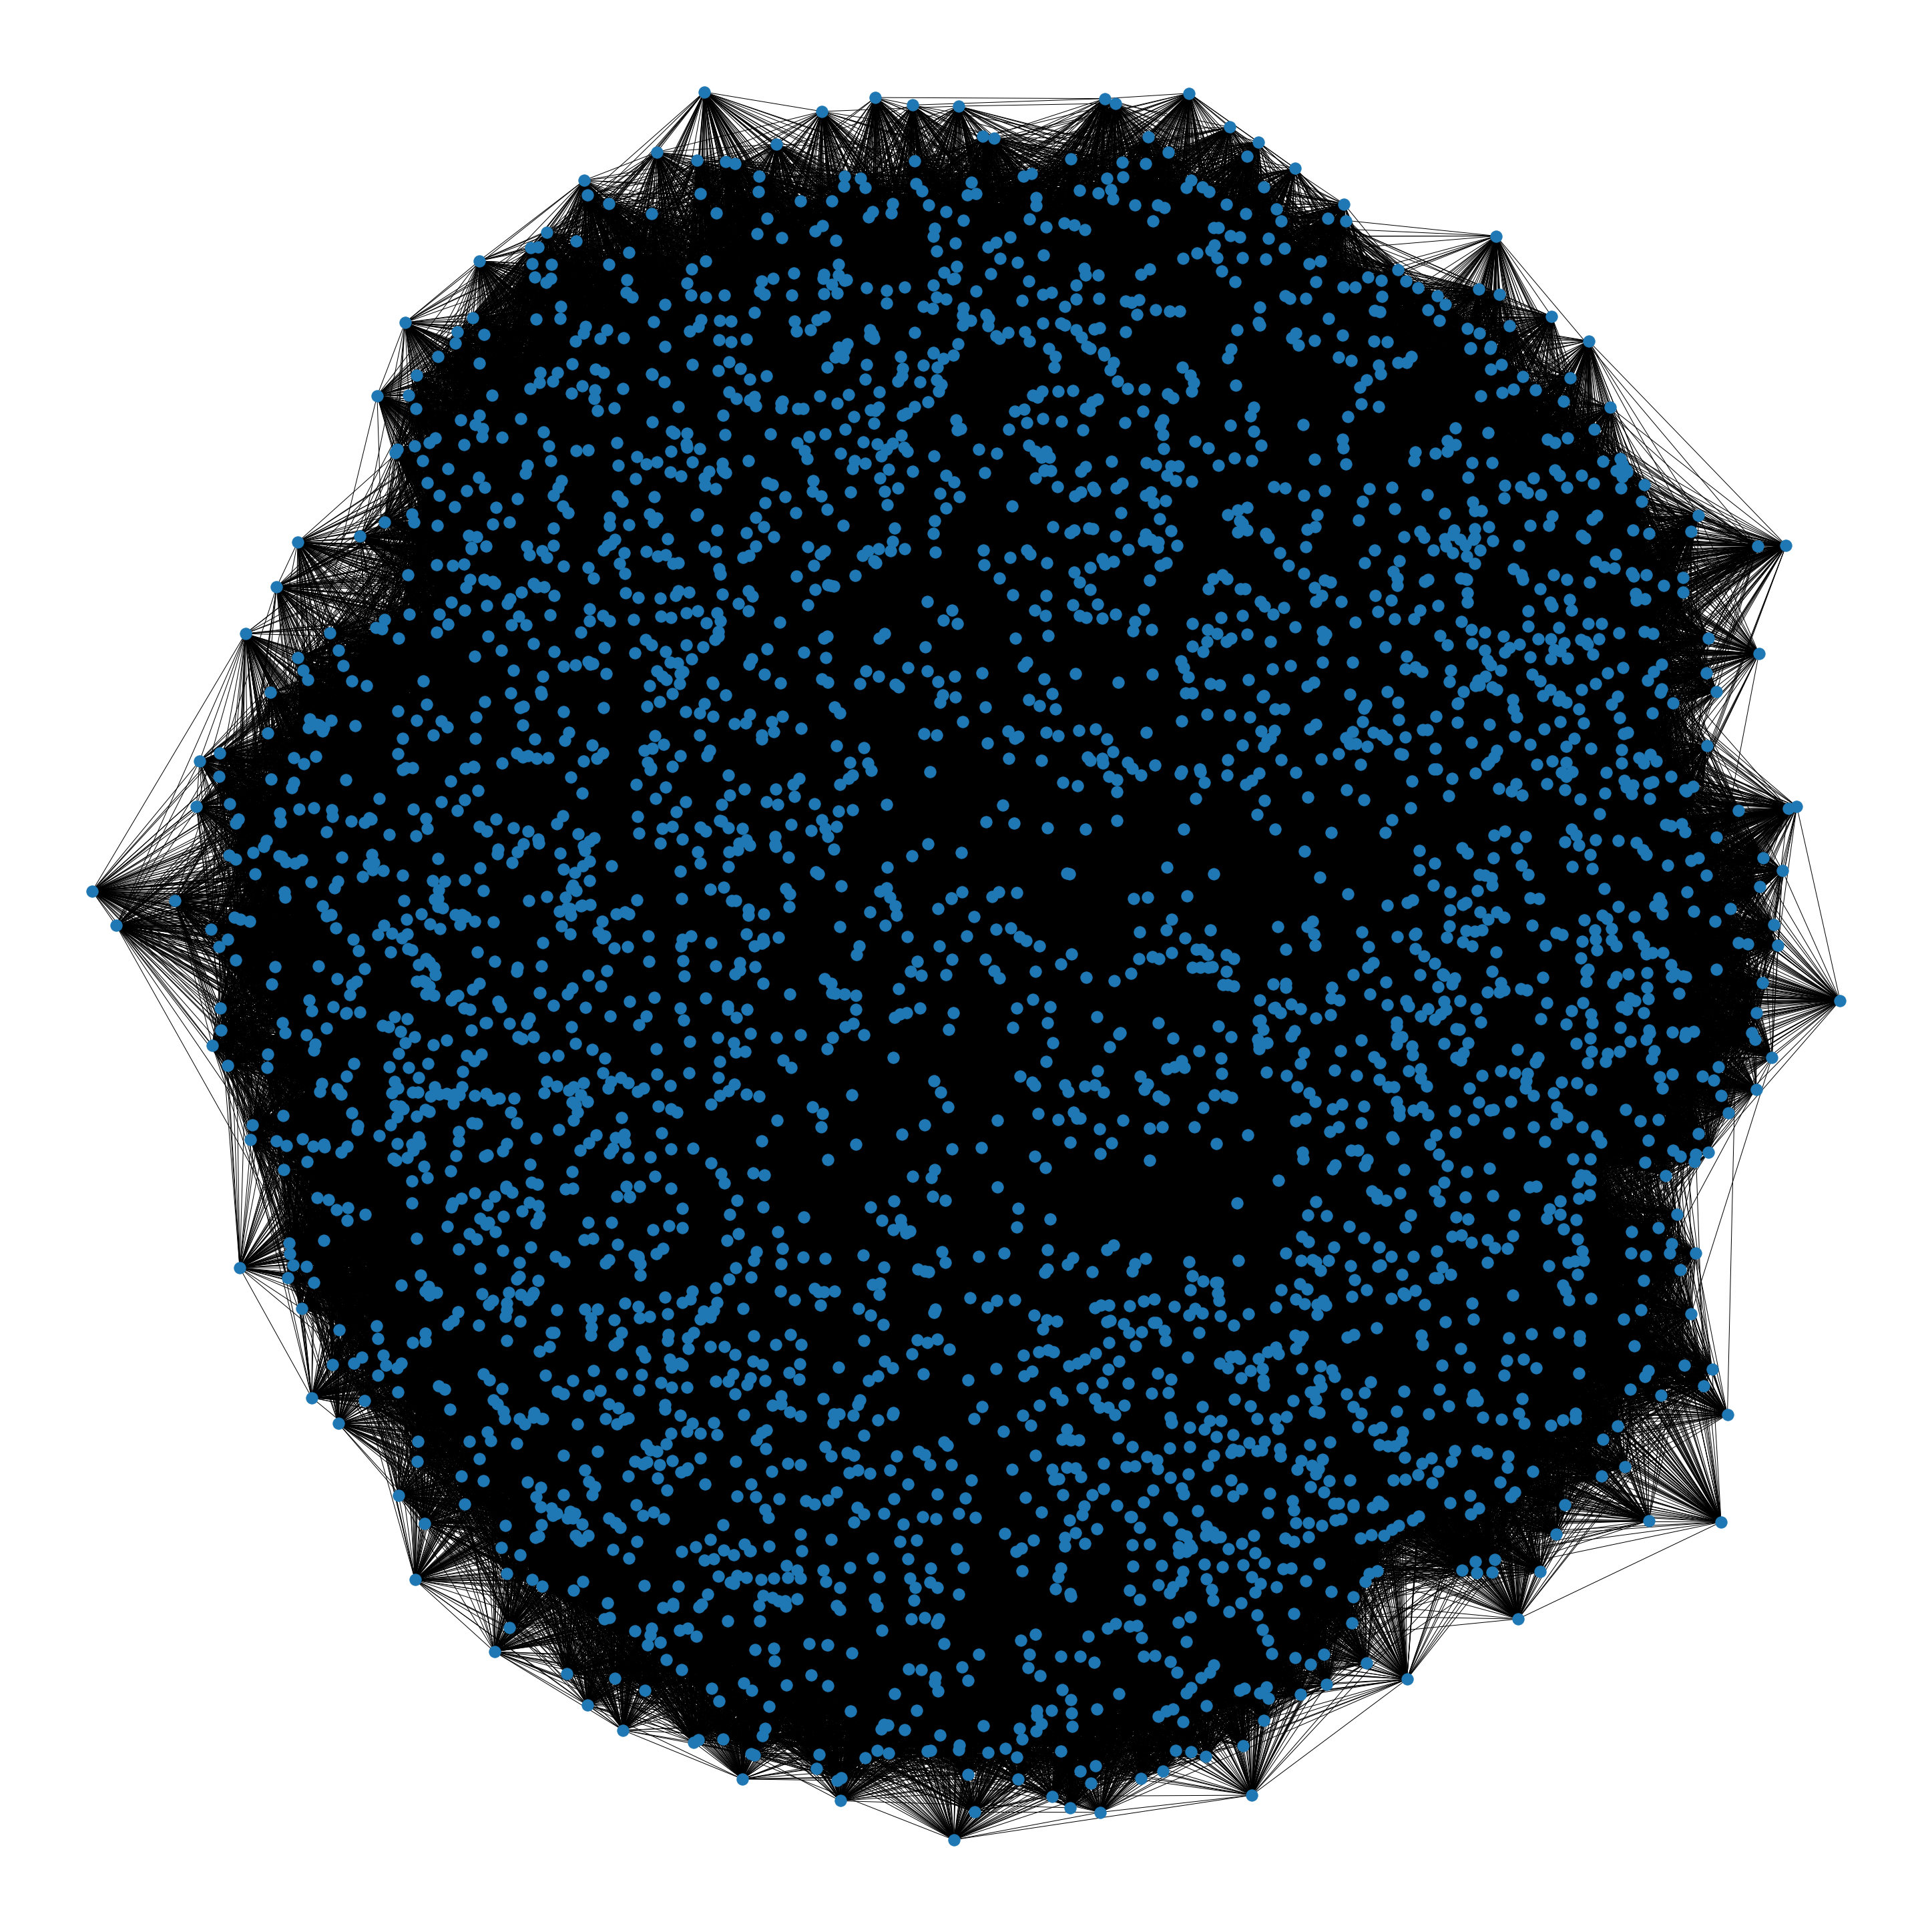

In [ ]:
ws = nx.watts_strogatz_graph(3535,114,0.2,seed=608)
print(nx.info(ws))
print('Average shortest path length: ', nx.average_shortest_path_length(ws))
print('Clustering coeff: ', nx.average_clustering(ws))
plt.figure(figsize=(40,40))
nx.draw(ws)

## 2. Recommendation Model

### 2.1 Models

#### 2.1.1 PangRank

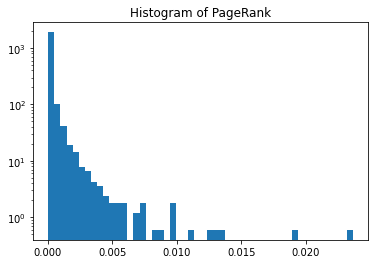

In [ ]:
pr = nx.pagerank(song_g)
plt.hist(list(pr.values()), density=True, bins=50)
plt.yscale('log')
plt.title("Histogram of PageRank")
plt.show()

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

#### 2.1.2 HITS

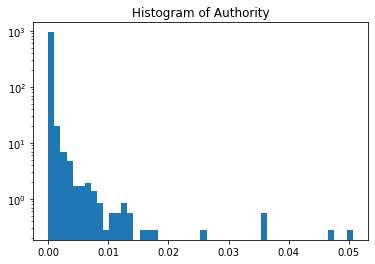

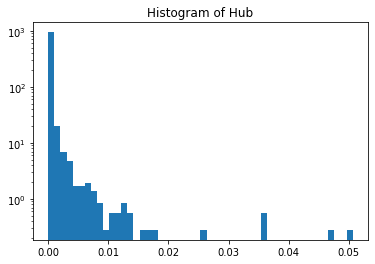

In [ ]:
h,a = nx.hits(song_g)
plt.hist(list(a.values()), density=True, bins=50)
plt.yscale('log')
plt.title("Histogram of Authority")
plt.show()
plt.hist(list(h.values()), density=True, bins=50)
plt.yscale('log')
plt.title("Histogram of Hub")
plt.show()

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

#### 2.1.3 Degree Centrality

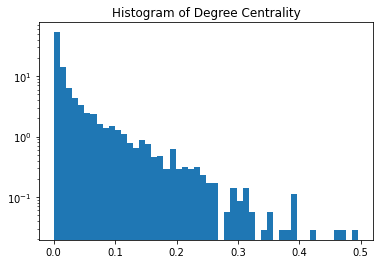

In [ ]:
dc = nx.degree_centrality(song_g)
plt.hist(list(dc.values()), density=True, bins=50)
plt.yscale('log')
plt.title("Histogram of Degree Centrality")
plt.show()

### 2.2 Evaluation

In [ ]:
def sort_dictionary(dic):
    sorted_dic = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)[0:50]
    sorted_list = [s[0] for s in sorted_dic]
    return sorted_list

def jaccard_similarity(dic1, dic2):
    list1 = sort_dictionary(dic1)
    list2 = sort_dictionary(dic2)
    sim = jaccard_similarity_score(list1, list2)
    return sim

#### 2.2.1 play_count

In [ ]:
song_list = play_count['song'].tolist()
playcount_list = play_count['play_count'].tolist()
index = [song_list.index(i) for i in song_list if i in list(song_g.nodes())]
playcount_g = [playcount_list[x] for x in index]
song_list_g = [song_list[x] for x in index]
playcount_dic = {}
for s,p in zip(song_list_g,playcount_g):
    playcount_dic[s]=p
sorted_playcount = sorted(playcount_dic.items(), key=operator.itemgetter(1), reverse=True)[0:50]
sorted_playcount_list = [s[0] for s in sorted_playcount]
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)[0:50]
sorted_pr_list = [s[0] for s in sorted_pr]

In [ ]:
playcount_pr_sim = jaccard_similarity(playcount_dic, pr)
playcount_a_sim = jaccard_similarity(playcount_dic, a)
playcount_h_sim = jaccard_similarity(playcount_dic, h)
playcount_dc_sim = jaccard_similarity(playcount_dic, dc)
print("The similarity between playcount and pagerank is:",playcount_pr_sim)
print("The similarity between playcount and authorities is:",playcount_a_sim)
print("The similarity between playcount and hubs is:",playcount_h_sim)
print("The similarity between playcount and degree_centrality is:",playcount_dc_sim)

The similarity between playcount and pagerank is: 0.1
The similarity between playcount and authorities is: 0.06
The similarity between playcount and hubs is: 0.06
The similarity between playcount and degree_centrality is: 0.04


#### 2.2.2 hotttnesss

In [ ]:
features = song_sample[['song_id','song_hotttnesss']]
song_list_f = features['song_id'].tolist()
hotness = features['song_hotttnesss'].tolist()
index_f = [song_list_f.index(i) for i in song_list_f if i in list(song_g.nodes())]
hotness_list= [hotness[x] for x in index_f]
song_list_f_g = [song_list_f[x] for x in index_f]
hotness_dic = {}
for s,hot in zip(song_list_f_g,hotness_list):
    hotness_dic[s]=hot

In [ ]:
hotness_pr_sim = jaccard_similarity(hotness_dic, pr)
hotness_a_sim = jaccard_similarity(hotness_dic, a)
hotness_h_sim = jaccard_similarity(hotness_dic, h)
hotness_dc_sim = jaccard_similarity(hotness_dic, dc)
print("The similarity between hotness and pagerank is:",hotness_pr_sim)
print("The similarity between hotness and authorities is:",hotness_a_sim)
print("The similarity between hotness and hubs is:",hotness_h_sim)
print("The similarity between hotness and degree_centrality is:",hotness_dc_sim)

The similarity between hotness and pagerank is: 0.02
The similarity between hotness and authorities is: 0.0
The similarity between hotness and hubs is: 0.0
The similarity between hotness and degree_centrality is: 0.02


"playcount" is a better reference than "hotness", and "pagerank" is the best 


### 2.3 Recommendation

#### 2.3.1 To User0

In [ ]:
user0 = user_total['user_id'].iloc[0]
songs_user0 = [i for song in songs_dict[user0] for i in song_g.neighbors(song)]
songs_user0_np = list(set(songs_user0))
songs_user0_recommend = [i for i in songs_user0_np if i not in songs_dict[user0]]

user0_recommend = {}
for i in songs_user0_recommend:
    user0_recommend[i]=pr[i]
    
sorted_user0_recommend = sorted(user0_recommend.items(), key=operator.itemgetter(1), reverse=True)
sorted_user0_recommend[0:10]

[('SOIZLKI12A6D4F7B61', 0.023642979043002256),
 ('SOULTKQ12AB018A183', 0.019352940314634),
 ('SOEHWGF12A6D4F8B2B', 0.013338341899902108),
 ('SOEKSGJ12A67AE227E', 0.013083140422271688),
 ('SOUCKDH12A8C138FF5', 0.012376786080076552),
 ('SONQBUB12A6D4F8ED0', 0.01133291509555253),
 ('SOKXYUW12A8C140229', 0.00979305508416553),
 ('SOBEVGM12A67ADBCA7', 0.009733300141824192),
 ('SOHTQAS12A6701C7BA', 0.009641206915111177),
 ('SOSQIHH12A8C13370B', 0.008750307358231398)]

#### 2.3.2 To All Users 

In [ ]:
def recommend_songs_pr(user):
    songs_user = [i for song in songs_dict[user] for i in song_g.neighbors(song)]
    songs_user_np = list(set(songs_user))
    songs_user_recommend = [i for i in songs_user_np if i not in songs_dict[user]]
    user_recommend = {}
    for i in songs_user_recommend:
        user_recommend[i]=pr[i]
    sorted_user_recommend = sorted(user_recommend.items(), key=operator.itemgetter(1), reverse=True)[0:10]
    return sorted_user_recommend

song_g_nodes = list(song_g.nodes)

recommend_dict_pr = {}
for key,value in songs_dict.items():
    if len(songs_dict[key])>=2:
        user_recommend = recommend_songs_pr(key)
        recommend_dict_pr[key]=user_recommend
    elif (len(songs_dict[key])==1) and (songs_dict[key][0] in song_g_nodes):
        user_recommend = recommend_songs_pr(key)
        recommend_dict_pr[key]=user_recommend

In [ ]:
user_id_pr = []
song_id_pr = []
for key, value in recommend_dict_pr.items():
    user_id_pr.append(key)
    song_id_pr.append([s[0] for s in value])

In [ ]:
recommendation_df = pd.DataFrame({'user_id':user_id_pr, 'song_id':song_id_pr})
recommendation_df.sample(10)

,user_id,song_id
4333,02b2b4e5bf435008e888929c8280c92626af713a,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
173323,6a4adb0f2bf02aab006ea5473c1e0eb88e1bbe71,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
150480,5c4ddec622adbe86bd4694dfa942bb634b7e47ea,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
389943,eee68c45307adaebe39c2cf0cdd665fb12c91a25,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
103924,3fd9de4ec1ba7b7df0098b8b93039918a186a837,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
321102,c4d2be0f91836ef7a1e883af09aa53a1493ed559,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
52720,206e7f9c02d48d4f0272b1e3bf6cd976c3e145b1,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
40608,19120332832d0863987684c14f9120e85bc8cf1b,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
79718,30e89f01c80202abd0f763ea0def833dd0060513,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."
293353,b3c58f1259c0712e5c99588c6b965486df71962b,"[SOIZLKI12A6D4F7B61, SOULTKQ12AB018A183, SOEHW..."


####2.4 Collaborative Filtering and comparison to Network Recommendation



In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 4.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670926 sha256=8079612b3e611b6065ac4bb65c023b97c5ccb1b0ac774d9ef6444ffaa0c67f3f
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNBaseline, SVDpp, NMF
from surprise import Dataset, Reader, accuracy
import os
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [ ]:
train_sp_subset = train[train['song'].isin(song_list_g)]
norm_playcount = [i/max(playcount_g)*5 for i in playcount_g]
playcount_df = pd.DataFrame({'song':song_list_g, 'norm_playcount':norm_playcount})
train_sp_merge = pd.merge(train_sp_subset, playcount_df, how="left", on=["song"])
train_sp_merge_norm = train_sp_merge.drop(columns=['play_count'])
train_sp_merge_norm.head(1)

,user,song,norm_playcount
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,0.116979


In [ ]:
trainset, testset = train_test_split(train_sp_merge_norm, test_size=0.5) 
reader = Reader(rating_scale=(0, 5), line_format='user item rating', sep=',', skip_lines=1)
data = Dataset.load_from_df(trainset[['user', 'song', 'norm_playcount']], reader=reader)
test = list(testset.to_records(index=False))

In [ ]:
svdpp = SVDpp()
cross_validate(svdpp, data, cv=3, verbose=True)
prediction = svdpp.test(test)
rmse = accuracy.rmse(prediction)
mae = accuracy.mae(prediction)
print("The RMSE for testset is:",rmse)
print("The MAE for testset is:",mae)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5101  0.5115  0.5083  0.5100  0.0013  
MAE (testset)     0.2037  0.2051  0.2039  0.2043  0.0006  
Fit time          29.51   29.73   29.59   29.61   0.09    
Test time         1.47    2.31    1.57    1.78    0.37    
RMSE: 0.5080
MAE:  0.2034
The RMSE for testset is: 0.5079731392906416
The MAE for testset is: 0.20337827138802114


The playcount was merged into the dataframe and used as the rating for the songs by users. The values of playcount were normalized to 0~5.
Then SVDpp has been used to fit the trainset and the evaluation has been done by calculating RMSE and MAE on testset. 

Make recommendation by Collaborative Filtering

In [ ]:
rating_list = []
for i in prediction:
    rating_list.append(i[3])

testset_new = testset
testset_new['Predict_playcount']=rating_list
testset_new.sample(5)

,user,song,norm_playcount,Predict_playcount
579329,4979b040f3c7a9a797438d7b04d327818d0787fc,SOZUOAK12AB018AA82,0.006467,0.232649
426696,26670298583d7e1e2a2796f8db71453db359b6e7,SOWQSUC12A6D4F969C,0.012820,0.294886
259437,edd55c5fc710b6f47e46e5aeaaba02ab3ff562ca,SOXDMAC12AB017E7FF,0.360552,0.371538
306273,aae7376d66fe90b807b28f8fec10910a4ff10b38,SOZAPQT12A8C142821,0.715038,0.722511
538862,645193bb9f44e402d42c543c13078f95959e8b6e,SOSDZUS12A8C13AE10,0.028100,0.170168


The recommendation songs should be filted based on the values of predicted playcount. But here, our main aim is to compare the recommendation result from network method and the result from the CF method, which will be talked about below:

Compare the recommendation result by network method to Collaborative Filtering and evaluate the result by mean playcount.

Randomly selected 5000 users and get the mean playcount of the recommended songs for them, compare the result between the network method and CF, or between the network method to the user history.

In [ ]:
import random
test_user_list = testset_new['user'].tolist()
test_users = list(set(test_user_list))
test_users_sp = random.choices(population=test_users, k=5000)

In [ ]:
test_user = [u for u in test_users_sp if u in user_id_pr]

In [ ]:
len(test_user)

5000

Creat the list of the mean playcount of the recommended songs of each user by CF

In [ ]:
from statistics import mean
playcount_mean_cf = []
for user in test_user:
    cf_recommendation = testset_new[testset_new.user==user].sort_values(by='Predict_playcount', ascending=False).head(10)
    top10_list = cf_recommendation['song'].tolist()
    if len(top10_list) >= 1:
        mean_playcount = mean([playcount_dic[s] for s in top10_list])
        playcount_mean_cf.append(mean_playcount)
mean_cf = mean(playcount_mean_cf)

In [ ]:
mean_cf

14447.988871349206

Creat the list of the mean playcount of the recommended songs of each user by network redommendation.

In [ ]:
playcount_mean_nx = []
for user in test_user:
    nx_top10_list = recommend_dict_pr[user]
    nx_top10_list_song = [a[0] for a in nx_top10_list]
    if len(nx_top10_list_song)>=1:
        nx_mean_playcount = mean([playcount_dic[s] for s in nx_top10_list_song])
        playcount_mean_nx.append(nx_mean_playcount)
mean_nx = mean(playcount_mean_nx)

In [ ]:
mean_nx

36792.725460396825

Creat the list of the mean playcount of the played songs of each user by user history

In [ ]:
playcount_mean_user = []
for user in test_user:
    user_history = train_sp_merge[train_sp_merge.user==user]
    user_song_list = user_history['song'].tolist()
    if len(user_song_list) >= 1:
        user_mean_playcount = mean([playcount_dic[s] for s in user_song_list])
        playcount_mean_user.append(user_mean_playcount)

mean_user = mean(playcount_mean_user)

In [ ]:
mean_user

14664.823686667187

t-test

In [ ]:
from scipy import stats
t_nx_cf, p_nx_cf = stats.ttest_ind(playcount_mean_nx,playcount_mean_cf)
print(t_nx_cf, p_nx_cf)

75.70616293498361 0.0


In [ ]:
t_nx_user, p_nx_user = stats.ttest_ind(playcount_mean_nx,playcount_mean_user)
print(t_nx_user, p_nx_user)

80.27467114633289 0.0


In [ ]:
t_cf_user, p_cf_user = stats.ttest_ind(playcount_mean_cf,playcount_mean_user)
print(t_cf_user, p_cf_user)

-0.5492100613816624 0.582873566003941


Based of the p-values, only the CF method with the user history has not significant difference. And the recommendation result of network method is better than CF method.

## 3. Challenge

In [ ]:
one_song_user = len(songs_dict)-len(recommend_dict_pr)
percentage_one_song_user = one_song_user/len(songs_dict)

In [ ]:
print('There are',one_song_user,'(',"{:%}".format(percentage_one_song_user),')','users who just selected one song which were not selected by others.')

## 4. Other Analysis

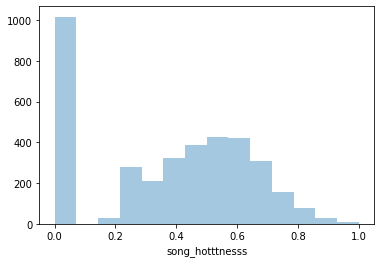

In [ ]:
sns.distplot(song_sample['song_hotttnesss'],kde=False)
plt.show()

In [ ]:
user_preference = train.merge(song_sample,left_on='song',right_on='song_id').groupby(['user']).mean()
user_preference

,play_count,artist_familiarity,artist_hotttnesss,duration,loudness,mode_confidence,song_hotttnesss
user,,,,,,,
00001638d6189236866af9bbf309ae6c2347ffdc,1.000000,0.780264,0.570107,177.710570,-15.015000,0.708000,0.597126
00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,2.000000,0.869997,0.802173,191.694783,-5.912333,0.445000,0.805576
000060ca4e6bea0a5c9037fc1bbd7bbabb98c754,1.000000,0.831929,0.594628,235.780770,-10.485000,0.463000,0.430161
00009d93dc719d1dbaf13507725a03b9fdeebebb,3.000000,0.516021,0.348527,78.810980,-13.484000,0.456000,0.257510
0000bb531aaa657c932988bc2f7fd7fc1b2050ec,3.333333,0.688861,0.429357,242.468117,-6.422000,0.378667,0.645463
...,...,...,...,...,...,...,...
ffff9de9f9ab522578ff9f1b188def1b7375a68f,1.000000,0.792256,0.566972,260.910570,-4.598000,0.481000,0.776127
ffffb628ff1e26c0b5d809a46e241d88108ea20c,1.000000,0.320855,0.291271,172.381590,-20.848000,0.613000,0.000000
ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,1.000000,0.681599,0.537537,313.207710,-7.465000,0.419000,0.474055


In [ ]:
!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import chart_studio

     |████████████████████████████████| 71kB 2.8MB/s 


In [ ]:
sample = pd.read_csv('cleaned-subset.csv')
map_df = sample.loc[:, ['artist_latitude', 'artist_longitude', 'artist_familiarity', 'artist_name', 'artist_location']].dropna()
chart_studio.tools.set_credentials_file(username='yyyyyokoko', api_key='NoVGkxcKvi17mgozh7kJ', )
chart_studio.tools.set_config_file(world_readable=True, sharing='public')
fig = px.scatter_mapbox(map_df, lat='artist_latitude', lon='artist_longitude', color='artist_familiarity', 
                        hover_data= ['artist_name', 'artist_location'], color_continuous_scale=px.colors.cyclical.IceFire,
                        center=dict(lat=38, lon=-94), zoom=2,
                        mapbox_style="carto-positron")
fig.show()

In [ ]:
a  = sample[['year','song_hotttnesss']].dropna().groupby(['year']).mean().reset_index()
fig = px.line(a, x="year", y="song_hotttnesss")
fig.show()